In [2]:
#Shucen Liu
#Assignment 1
#CMSC 25025

from pyspark.sql import SparkSession
from pyspark.sql import Row
import os
import re

spark = SparkSession.builder \
    .master('local') \
    .appName('Spark Try') \
    .getOrCreate()
df = spark.read.json('/project/cmsc25025/sou/speeches.json')

#4a
speech = df.rdd.map(lambda x: (str(x['president']), int(x['year']), re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', x['text'].replace('\r\n', '')),
                              re.split(" ", x['text'].replace('\r\n', ''))))



4(b)
The first graph is the relation between year and the number of sentences
The second graph is the relation between year and the average length of sentence


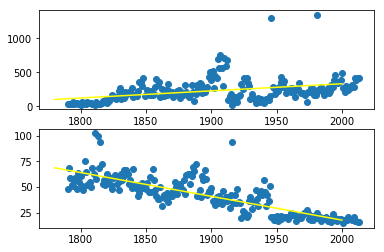

From the plots, we can see that over the years, state of the Union address tends to have
shorter sentences, while the number of sentences also increse steadily over the years.
This may be due to the fact that, in the past, SOU addresses were delivered through written letters,
but in the later days, were distributed through radios. Thus shorter sentences are easier for the audience to follow.


In [4]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from matplotlib import pyplot as plt
import numpy as np
import os
import re


#4b

print '4(b)'
speech_count = speech.map(lambda x: Row(year = x[1], president = x[0], num_sentence = len(x[2]), 
                                        avg_length = len(x[3])/len(x[2]), 
                                       total_words = len(x[3])))

Speeches = spark.createDataFrame(speech_count)

Speeches.createOrReplaceTempView('speeches')

num_of_sentences = spark.sql("SELECT year, num_sentence, avg_length FROM speeches")

plot1_data = num_of_sentences.collect()

yr = []
num = []
length = []
for row in plot1_data:
    data = (row['year'], row['num_sentence'], row['avg_length'])
    yr.append(data[0])
    num.append(data[1])
    length.append(data[2])
def find_reg(x, y, min_, max_):
    cov = np.cov(x, y)[0][1]
    var = np.cov(x, y)[0][0]
    beta = cov/var
    alpha = np.mean(y) - beta*np.mean(x)
    reg_line_x = [min_, max_]
    reg_line_y = [alpha + min_ * beta, alpha + max_ * beta]
    return reg_line_x, reg_line_y
    
line1 = find_reg(yr, num, 1780, 2000)
line2 = find_reg(yr, length, 1780, 2000)
print "The first graph is the relation between year and the number of sentences"
print "The second graph is the relation between year and the average length of sentence"
plt.figure(1)
plt.subplot(211)
plt.scatter(yr, num)
plt.plot(line1[0], line1[1], color = 'yellow')

plt.subplot(212)
plt.scatter(yr, length)
plt.plot(line2[0], line2[1], color = 'yellow')
plt.show()

print 'From the plots, we can see that over the years, state of the Union address tends to have'
print 'shorter sentences, while the number of sentences also increse steadily over the years.'
print 'This may be due to the fact that, in the past, SOU addresses were delivered through written letters,'
print 'but in the later days, were distributed through radios. Thus shorter sentences are easier for the audience to follow.'

4(c)
The first plot is year Versus total words up to year 1913.
The second plot is year Versus total words after 1913


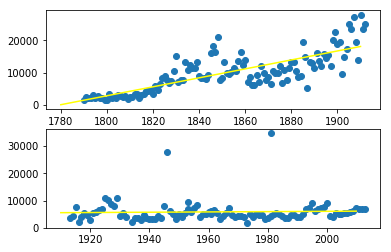

Prior to 1913, the total words of SOU speech increase every year, since the 19th century.
However, after 1913, the total number of words drop sharply (compared to year 1912, 1911).
This is due to the fact that in 1800 - 1912, SOU speeches were not delivered by the president in person,
but were read by a clerk. The rule changes in 1913, the president has to deliver it in person;
thus these speeches become significantly shorter.


In [6]:
#4(c)

words1 = spark.sql("SELECT year, total_words FROM speeches WHERE year < 1913")
words2 = spark.sql("SELECT year, total_words FROM speeches WHERE year >= 1913")

plot2_data1 = words1.collect()
plot2_data2 = words2.collect()

plot2_year1 = []
plot2_year2 = []
plot2_words1 = []
plot2_words2 = []

for row in plot2_data1:
    plot2_year1.append(row[0])
    plot2_words1.append(row[1])
for row in plot2_data2:
    plot2_year2.append(row[0])
    plot2_words2.append(row[1])

    
line_1 = find_reg(plot2_year1, plot2_words1, 1780, 1910)
line_2 = find_reg(plot2_year2, plot2_words2, 1910, 2010)

print '4(c)'
print 'The first plot is year Versus total words up to year 1913.'
print 'The second plot is year Versus total words after 1913'
plt.figure(1)
plt.subplot(211)
plt.scatter(plot2_year1, plot2_words1)
plt.plot(line_1[0], line_1[1], color = 'yellow')

plt.subplot(212)
plt.scatter(plot2_year2, plot2_words2)
plt.plot(line_2[0], line_2[1], color = 'yellow')
plt.show()

print 'Prior to 1913, the total words of SOU speech increase every year, since the 19th century.'
print 'However, after 1913, the total number of words drop sharply (compared to year 1912, 1911).'
print 'This is due to the fact that in 1800 - 1912, SOU speeches were not delivered by the president in person,'
print 'but were read by a clerk. The rule changes in 1913, the president has to deliver it in person;' 
print 'thus these speeches become significantly shorter.'

In [8]:
#4(d)

import numpy as np

president_length = spark.sql("SELECT president, avg_length FROM speeches")
length_sum = president_length.rdd.map(lambda x: (x['president'], (x['avg_length'], 1)))
sentence_sum = length_sum.reduceByKey(lambda (a1, a2), (b1, b2): (a1 + b1, a2 + b2))
president_sen_avg = sentence_sum.map(lambda x : Row(president = x[0], sentence_len = (x[1][0]/x[1][1])))

President = spark.createDataFrame(president_sen_avg)
President.createOrReplaceTempView('President')

max_len = spark.sql("SELECT * FROM President ORDER BY sentence_len DESC LIMIT 1")
min_len = spark.sql("SELECT * FROM President ORDER BY sentence_len ASC LIMIT 1")

print '4(d)'
print "The president with the longest sentence on average is James Madison. \n", max_len.collect()
print "The president with the shortest sentence on average is George Bush. \n",min_len.collect()

def get_quantiles(rdd):
    quantiles = []
    rdd_count = rdd.count()
    print rdd_count
    sorted_rdd = rdd.sortBy(lambda x: x['sentence_len']).zipWithIndex().map(lambda x: (x[1], x[0]))
    for p in [0.25, 0.5, 0.75]:
        pv = sorted_rdd.lookup(np.ceil(rdd_count * p) - 1)[0]
        quantiles.append(pv)
    return quantiles

presidents = get_quantiles(president_sen_avg)

print "The president at the quantiles are: \n", presidents

from pyspark import SparkContext, SparkConf
sc = spark.sparkContext
speech_sen = speech.map(lambda x: x[2]).reduce(lambda a, b: a + b)
speech_sen_len = sc.parallelize(speech_sen).map(lambda x: Row(sentence = x, length = len(x.split(' '))))
speech_sen_len.take(1)
sentences = spark.createDataFrame(speech_sen_len)
sentences.createOrReplaceTempView('sentences')

longest_sentence = spark.sql("SELECT * FROM sentences ORDER BY length DESC LIMIT 1 ")
shortest_sentence = spark.sql("SELECT * FROM sentences ORDER BY length ASC LIMIT 1 ")
print "The longest sentence is: \n", longest_sentence.collect()
print "The sortest sentence is: ", shortest_sentence.collect()

4(d)
The president with the longest sentence on average is James Madison. 
[Row(president=u'James Madison', sentence_len=78)]
The president with the shortest sentence on average is George Bush. 
[Row(president=u'George Bush', sentence_len=17)]
41
The president at the quantiles are: 
[Row(president=u'Calvin Coolidge', sentence_len=23), Row(president=u'Franklin D. Roosevelt', sentence_len=42), Row(president=u'James Monroe', sentence_len=55)]
The longest sentence is: 
[Row(length=1159, sentence=u'If, for example, the Executive were empowered to apply to Spanish vessels and cargoes from Cuba and Puerto Rico the same rules of treatment and scale of penalties for technical faults which are applied to our vessels and cargoes in the Antilles, a resort to that course might not be barren of good results.The report of the Secretary of the Treasury gives a full and interesting exhibit of the financial condition of the country.It shows that the ordinary revenues from all sources for the fiscal year